# Wasserstein GAN with Gradient Penalty for Molecular Graph images

This block

- imports all modules/libraries needed
- contains a function for a learning rate scheduler (if needed)
- reads in SMILES strings and creates a list
- featurizes via the SmilesTo Image featurizer from Deepchem (https://github.com/deepchem/deepchem)
- Four channel image used for featurization
  * Atomic numbers + bonds
  * partial charges
  * valence
  * hybridization

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
from rdkit import Chem
from functools import partial
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split

def exp_decay(lr0,s):
    def exp_decay_fcn(epoch):
        return lr0*0.1**(epoch/s)
    return exp_decay_fcn

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv("621-azo.csv")
df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurizer

featurizer=dc.feat.SmilesToImage(img_spec="engd")
featname="SmilesToImage"

f = featurizer.featurize(Xa)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to lambdamax
y = df["Lmax"]

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:,:,:], y=y[:nnp], ids=Xa[:nnp], w=w[:nnp])


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\ProgramData\Anaconda3\envs\rdkitenv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Number of features and datapoints:  (6731, 80, 80, 4)
featurization done with:  SmilesToImage


## Define the Critic and Generator

- architecture adapted from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

In [11]:
embsize=128
dropout_rate = 0.3

#=======================================================================================================

critic_input = tf.keras.layers.Input(shape=[80,80,4])
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(4,4), strides=2,padding="same")(critic_input)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=128,kernel_size=(4,4), strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=256,kernel_size=(4,4), strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=512,kernel_size=(4,4), strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=1,padding="valid")(x)
critic_output = tf.keras.layers.Flatten()(x)

critic = tf.keras.models.Model(critic_input,critic_output)
#=======================================================================================================

generator_input = tf.keras.layers.Input(shape=(embsize,))
x = tf.keras.layers.Reshape((1,1,embsize))(generator_input)
x = tf.keras.layers.Conv2DTranspose(filters=512,kernel_size=(5,5),strides=1, padding="valid", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides=2, padding="same", use_bias = False)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
generator_output = tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(4,4),strides=2, padding="same", 
                                                   activation = "sigmoid")(x)  #using activation = "sigmoid" here leads to blue backgrounds

generator = tf.keras.models.Model(generator_input,generator_output)

print("Critic and Generator built.")

Critic and Generator built.


## Training loop for the Wasserstein GAN with Gradient Penalty

- Training loop adapted from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

In [12]:
class WGANGP(tf.keras.models.Model):
    def __init__(self,critic,generator,latent_dim,critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP,self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = tf.keras.metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = tf.keras.metrics.Mean(name="c_gp")
        self.c_loss_metric = tf.keras.metrics.Mean(name="c_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [ self.c_loss_metric, self.c_wass_loss_metric,
                self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self,batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size,1,1,1],0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training = True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis = [1,2,3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))

            with tf.GradientTape() as tape:
                generated_images = self.generator(random_latent_vectors, training = True)
                real_predictions = self.critic(real_images, training = True)
                fake_predictions = self.critic(generated_images, training = True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, generated_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient,self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training = True)
            fake_predictions = self.critic(generated_images, training = True)
            g_loss = -tf.reduce_mean(fake_predictions)
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        self.c_loss_metric.update_state(c_loss)
        self.g_loss_metric.update_state(g_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)

        return {m.name: m.result() for m in self.metrics}

wgangp = WGANGP(critic = critic, generator = generator, latent_dim = embsize,
               critic_steps = 3, gp_weight = 10.0)

print("Wasserstein GAN with Gradient Penalty built.")

Wasserstein GAN with Gradient Penalty built.


## Train the WGAN-GP

In [13]:
wgangp.compile(c_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.999),
               g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.999))

wgangp.fit(dataset.X, epochs = 25, batch_size = 64)

Epoch 1/25
106/106 [==============================] - 419s 4s/step - c_loss: -230.1199 - c_wass_loss: -397.1971 - c_gp: 16.7077 - g_loss: 389.5749
Epoch 2/25
106/106 [==============================] - 424s 4s/step - c_loss: -127.3054 - c_wass_loss: -208.7862 - c_gp: 8.1481 - g_loss: 169.1725
Epoch 3/25
106/106 [==============================] - 427s 4s/step - c_loss: -85.9189 - c_wass_loss: -133.7031 - c_gp: 4.7784 - g_loss: 76.1599
Epoch 4/25
106/106 [==============================] - 437s 4s/step - c_loss: -76.1074 - c_wass_loss: -116.5217 - c_gp: 4.0414 - g_loss: 46.4453
Epoch 5/25
106/106 [==============================] - 441s 4s/step - c_loss: -72.9403 - c_wass_loss: -110.9859 - c_gp: 3.8046 - g_loss: 40.9871
Epoch 6/25
106/106 [==============================] - 428s 4s/step - c_loss: -70.5768 - c_wass_loss: -107.9426 - c_gp: 3.7366 - g_loss: 35.9796
Epoch 7/25
106/106 [==============================] - 432s 4s/step - c_loss: -67.4326 - c_wass_loss: -102.7342 - c_gp: 3.5302 - g_l

## Plot generated images

- use the generator to make a couple of images

1/1 [==============================] - 0s 59ms/step
(2, 80, 80, 4)


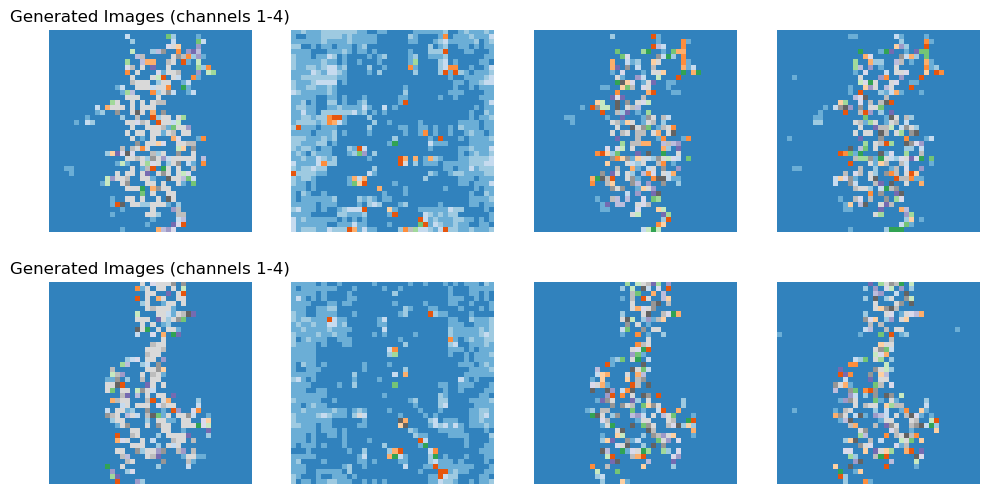

In [18]:
#load a model
#decoder = tf.keras.models.load_model("6731_1April_test_Wassgenerator")

z_gen = np.random.normal(size=(2,embsize))

recons_embed = generator.predict(z_gen)
print(recons_embed.shape)

from matplotlib import pyplot as plt
from scipy import ndimage

cmap="tab20c"

def new_images(image,channel):
    recons = image[:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot

newimages=[]
newimages2=[]
for i in range(4):
    new1 = new_images(image=recons_embed[0],channel=i)
    newimages.append(new1)
    new1 = new_images(image=recons_embed[1],channel=i)
    newimages2.append(new1)
    
#can insert scaling code here

fig, arrax = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    arrax[0,i].imshow(newimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
arrax[0,0].set_title("Generated Images (channels 1-4)")
arrax[1,0].set_title("Generated Images (channels 1-4)")

plt.show()

## Save WGAN-GP components

In [15]:
critic.save("6731_1April_test_critic",save_format="tf")
print("Critic model saved.")

generator.save("6731_1April_test_Wassgenerator",save_format="tf")
print("Generator model saved.")

INFO:tensorflow:Assets written to: 6731_1April_test_critic\assets


INFO:tensorflow:Assets written to: 6731_1April_test_critic\assets


Critic model saved.


INFO:tensorflow:Assets written to: 6731_1April_test_Wassgenerator\assets


INFO:tensorflow:Assets written to: 6731_1April_test_Wassgenerator\assets


Generator model saved.


## Load and restart training on the Wasserstein GAN with Gradient Penalty

In [9]:
#critic = tf.keras.models.load_model("6731_1April_test_critic")
#generator = tf.keras.models.load_model("6731_1April_test_Wassgenerator")
epcs = 30

wgangp.compile(c_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.999),
               g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.999))

wgangp.fit(dataset.X, epochs = epcs+10, batch_size = 64, initial_epoch = epcs)

Epoch 31/40
106/106 [==============================] - 448s 4s/step - c_loss: -54.6430 - c_wass_loss: -82.1224 - c_gp: 2.7479 - g_loss: 74.4574
Epoch 32/40
106/106 [==============================] - 460s 4s/step - c_loss: -53.7754 - c_wass_loss: -80.4547 - c_gp: 2.6679 - g_loss: 80.4183
Epoch 33/40
106/106 [==============================] - 444s 4s/step - c_loss: -55.4084 - c_wass_loss: -81.7291 - c_gp: 2.6321 - g_loss: 93.0261
Epoch 34/40
106/106 [==============================] - 448s 4s/step - c_loss: -54.9578 - c_wass_loss: -81.5332 - c_gp: 2.6575 - g_loss: 102.9184
Epoch 35/40
106/106 [==============================] - 456s 4s/step - c_loss: -55.8520 - c_wass_loss: -82.4011 - c_gp: 2.6549 - g_loss: 126.5514
Epoch 36/40
106/106 [==============================] - 444s 4s/step - c_loss: -54.2432 - c_wass_loss: -80.5514 - c_gp: 2.6308 - g_loss: 155.4334
Epoch 37/40
106/106 [==============================] - 444s 4s/step - c_loss: -53.6977 - c_wass_loss: -79.0904 - c_gp: 2.5393 - g_los

## Code for scaling images

In [ ]:
#scaling for images
biggest, smallest = 0.0, 6000.0
tmp=np.empty(2)
for i in range(4):
    tmp[0] = newimages[i].max()
    tmp[1] = oldimages[i].max()
    tmps = tmp.max()
    if tmps > biggest:
        biggest = tmps
    tmp[0] = newimages[i].min()
    tmp[1] = oldimages[i].min()
    tmps = tmp.min()
    if tmps < smallest:
        smallest = tmps
scaled_newimages = ((newimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')
scaled_oldimages = ((oldimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')